# Bank X Digital Transformation Model | Random Forest

- A bank X is on a massive digital transformation for all its departments. 
- Bank has a growing customer base, majority of them are liability customers vs borrowers. 
- The bank is interested in expanding the borrowers base rapidly to bring in more business via loan interests. 
- A campaign that the bank ran in last quarter showed an average single digit conversion rate. 
- Digital transformation being the core strength of the business strategy, marketing department wants to devise effective campaigns with better target marketing to increase the conversion ratio to double digitwith same budget as per last campaign.

DATA DESCRIPTION: The data consists of the following attributes:
1. `ID`: Customer ID
2. `Age`:Customer’s approximate age.
3. `CustomerSince`: Customer of the bank since. [encrypted unit]
4. `HighestSpend`: Customer’s highest spend so far in one transaction. [encrypted unit]
5. `ZipCode`: Customer’s zip code.
6. `HiddenScore`: A score associated to the customer which is masked by the bank as an IP.
7. `MonthlyAverageSpend`: Customer’s monthly average spend so far. [encrypted unit]
8. `Level`:A level associated to the customer which is masked by the bank as an IP.
9. `Mortgage`:Customer’s mortgage. [encrypted unit]
10. `Security`: Customer’s security asset with the bank. [encrypted unit]
11. `FixedDepositAccount`: Customer’s fixed deposit account with the bank. [encrypted unit]
12. `InternetBanking`: if the customer uses internet banking.
13. `CreditCard`: if the customer uses bank’s credit card.
14. `LoanOnCard`: if the customer has a loan on credit card.

PROJECT OBJECTIVE: Build an AIML model to perform focused marketing by predicting
customers who willconvert using the historical dataset.

# Import: Libraries and Dataset

In [25]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from src.util import check_imbalance, get_feature_importance, random_forest_tuning
from src.viz import plot_corr, plot_histograms, plot_roc_curve, plot_confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] == 300

False

In [2]:
# import and merging the datasets
df1 = pd.read_csv('../data/randomforest_1.csv')
df2 = pd.read_csv('../data/randomforest_2.csv')
display(df1.shape,df2.shape)
df = pd.merge(df1, df2, on='ID', how='inner',
               validate="one_to_one")
display(df.shape)
# converting column names into lowercase
df.columns = df.columns.str.lower()

(5000, 8)

(5000, 7)

(5000, 14)

In [3]:
# glancing at the dataset
display(df.sample(5))

,id,age,customersince,highestspend,zipcode,hiddenscore,monthlyaveragespend,level,mortgage,security,fixeddepositaccount,internetbanking,creditcard,loanoncard
4310,4311,65,41,170,94143,4,6.10,2,0,0,1,1,1,1.0
3641,3642,59,35,74,94402,4,2.30,3,0,0,0,0,0,0.0
1087,1088,38,13,54,92028,3,0.70,2,196,0,0,0,0,0.0
2879,2880,42,15,73,94545,3,2.33,2,0,0,0,0,0,0.0
4251,4252,42,16,62,95064,3,0.90,3,0,0,0,1,0,0.0


# Data Cleaning 

In [4]:
# checking for missing value
df.isnull().sum()

id                      0
age                     0
customersince           0
highestspend            0
zipcode                 0
hiddenscore             0
monthlyaveragespend     0
level                   0
mortgage                0
security                0
fixeddepositaccount     0
internetbanking         0
creditcard              0
loanoncard             20
dtype: int64

There are 20 missing values in `loanoncard`
for the missing value treatment, dropping 20 records sincethey only make for 0.4% of the total dataset size and wouldn't have any significant dataloss.

In [5]:
# dropping the mising value
print(df.shape)
df = df.dropna()
print(df.shape)

(5000, 14)
(4980, 14)


For modelling, columns like id and zipcode are not useful since they are nominal and don't affect the outputs and we have already joined the dataset

In [6]:
# dropping the mising value
print(df.shape)
df = df.drop(columns=['id','zipcode'], axis=1)
print(df.shape)

(4980, 14)
(4980, 12)


# Exploratory Data Analysis

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,4980.0,45.352610,11.464212,23.0,35.0,45.0,55.000,67.0
customersince,4980.0,20.117671,11.468716,-3.0,10.0,20.0,30.000,43.0
highestspend,4980.0,73.852410,46.070090,8.0,39.0,64.0,98.000,224.0
hiddenscore,4980.0,2.395582,1.147200,1.0,1.0,2.0,3.000,4.0
monthlyaveragespend,4980.0,1.939536,1.750006,0.0,0.7,1.5,2.525,10.0
level,4980.0,1.880924,0.840144,1.0,1.0,2.0,3.000,3.0
mortgage,4980.0,56.589759,101.836758,0.0,0.0,0.0,101.000,635.0
security,4980.0,0.104418,0.305832,0.0,0.0,0.0,0.000,1.0
fixeddepositaccount,4980.0,0.060643,0.238697,0.0,0.0,0.0,0.000,1.0
internetbanking,4980.0,0.597189,0.490513,0.0,0.0,1.0,1.000,1.0



Age:
- The average age of the customers is approximately 45 years.
- Most customers fall within the age range of 35 to 55 years.
- The youngest customer is 23 years old, and the oldest is 67 years.

Customer Since:
- Customers have been with the bank for an average of 20 years.
- The range of customer tenure spans from -3 to 43 years.
- A significant portion of customers has been with the bank for 10 to 30 years.

Highest Spend:
- The highest spend in one transaction ranges from 8 to 224 (in some undisclosed unit).
- The average highest spend is approximately 73, with a variation around 46.

Hidden Score:
- The hidden score associated with customers ranges from 1 to 4.
- The average hidden score is approximately 2, with a variation around 1.

Monthly Average Spend:
- The average monthly spending ranges from 0 to 10 (in some undisclosed unit).
- Most customers have a monthly average spend between 0.7 and 2.5.

Level:
- The level associated with customers ranges from 1 to 3.
- The average level is approximately 1.88.

Mortgage:
- Mortgage amounts range from 0 to 635 (in some undisclosed unit).
- The average mortgage is around 56, with considerable variation.

Security:
- Most customers have no security assets with the bank (values are 0).
- Some customers have security assets, with values up to 1.

Fixed Deposit Account:
- The majority of customers do not have a fixed deposit account with the bank (values are 0).
- Some customers have a fixed deposit account, with values up to 1.

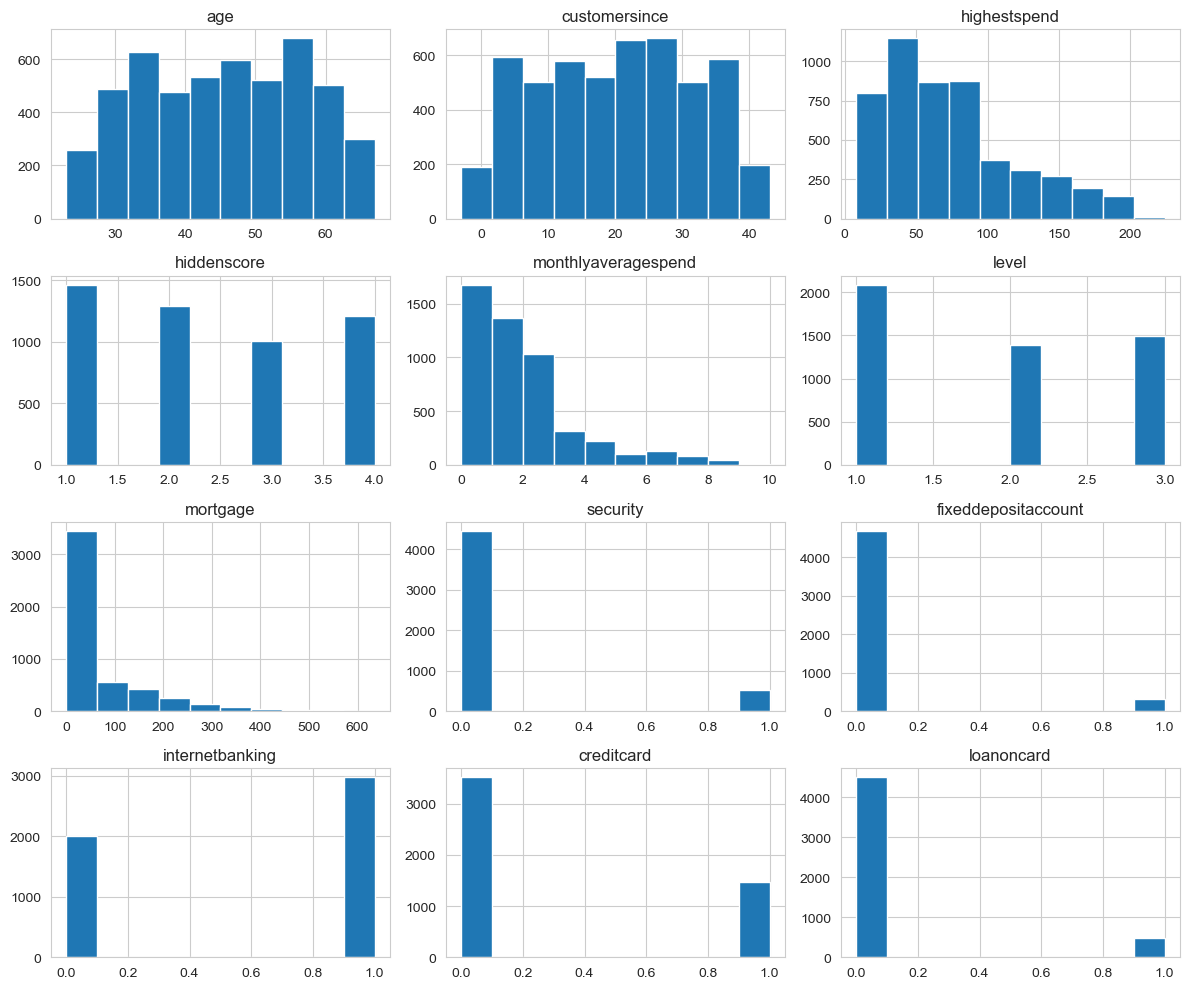

In [8]:
# creating histogram for all the variables
columns = df.columns.to_list()
plot_histograms(df,column=columns)

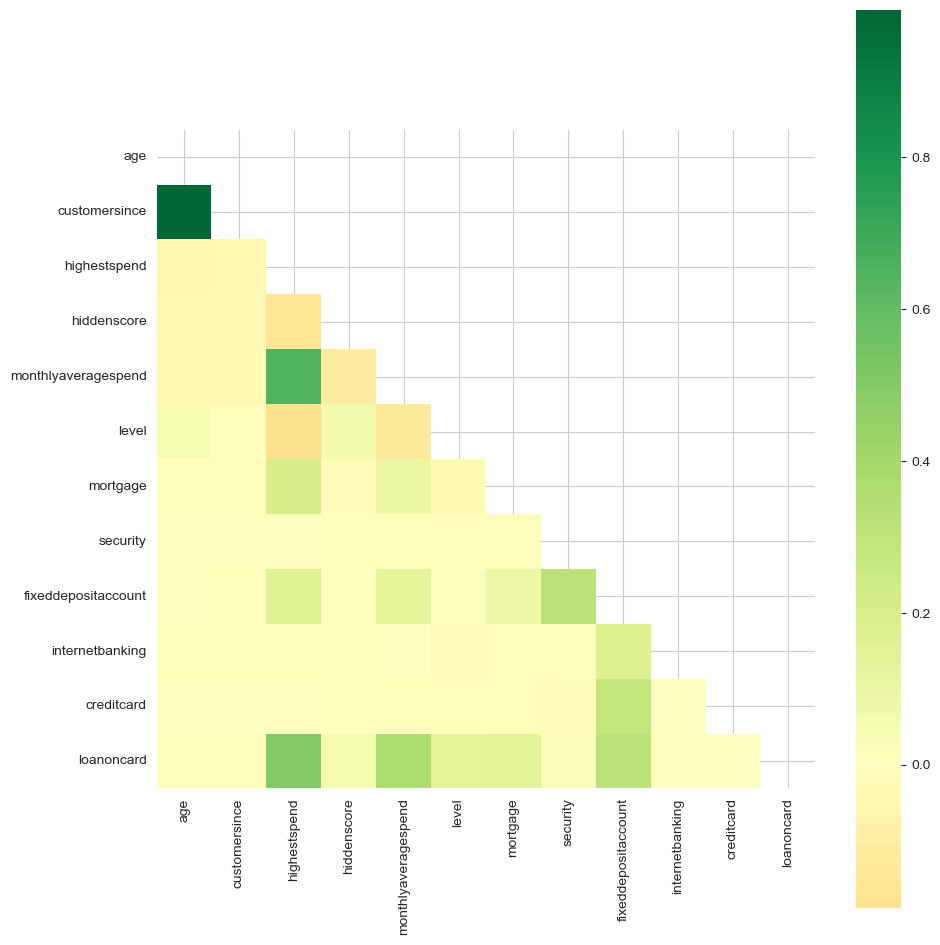

In [9]:
corr = df.corr()
plot_corr(corr, annot=False)

- `age` is highly overall correlated with `customersince`
- `highestspend` is highly correlated with `loanoncard`
- `highestspend` is highly correlated with `monthlyaveragespend`m

# Data Pre-Processing

In [10]:
# checking the distribution of target variable
check_imbalance(df,class_column='loanoncard')

# splitting into independent and dependent variable
X = df.drop(['loanoncard'], axis=1)
y = df['loanoncard']

# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

Number of true: 480 (9.64%)
Number of false: 4500 (90.361%)


# Model training: Random forest

In [11]:
# creating a model
random_forest = RandomForestClassifier(n_estimators=10, random_state=23)
# fitting the variable
random_forest.fit(X_train,y_train)
# checking the accuracyscore of a classifier on both train and test
print(f"Training set accuracy {random_forest.score(X_train, y_train)}")
print(f"Testing set accuracy {random_forest.score(X_test,y_test)}")

Training set accuracy 0.9991394148020654
Testing set accuracy 0.9825970548862115


Using GridSearchCV to use hyper-parameters

In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

search = GridSearchCV(random_forest,
                      param_grid=param_grid,
                      cv=3, scoring='accuracy')

search.fit(X_train, y_train)
search.best_params_

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

Best features

In [13]:
random_forest = RandomForestClassifier(n_estimators=100,
                                        max_depth=20,
                                        random_state=1,
                                        min_samples_leaf=2)
random_forest.fit(X_train, y_train)
train_pred = random_forest.predict_proba(X_train)
test_pred = random_forest.predict_proba(X_test)
print("train auc : ",round( roc_auc_score(y_train , train_pred[:,1]),4))
print("test auc : ",round( roc_auc_score(y_test , test_pred[:,1]),4))

train auc :  1.0
test auc :  0.9941


In [14]:
get_feature_importance(X_train,random_forest,5)

,name,importance
2,highestspend,0.358882
5,level,0.224573
4,monthlyaveragespend,0.172505
3,hiddenscore,0.104564
8,fixeddepositaccount,0.045883


# Model Training: Logistic Regression

In [15]:
# creating the model
log_model = LogisticRegression()
# training the model by fitting the variables
log_model.fit(X_train, y_train)
# checking it's output
print("Training score:", log_model.score(X_train, y_train))
print("Testing score:", log_model.score(X_test, y_test))

Training score: 0.948938611589214
Testing score: 0.9471218206157965


c:\Users\Asif Sayyed\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
y_pred = log_model.predict(X_test)
# calculating the accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
# calculating the precision
precision = metrics.precision_score(y_test, y_pred)
# calculating the recall
recall = metrics.recall_score(y_test, y_pred)
# calculating the f1 score
f1 = metrics.f1_score(y_test, y_pred)

# printing out the results
print(f"The  model has an accuracy of {accuracy*100:.2f}%")
print(f"Precision is {precision*100 : .2f} %")
print(f"Recall is {recall*100 : .2f}%")
print(f"F1 Score is {f1 * 100 : .2f}")

The  model has an accuracy of 94.71%
Precision is  85.71 %
Recall is  54.17%
F1 Score is  66.38


In [18]:
X_train['pred_prob'] = log_model.predict(X_train)
X_test['pred_prob'] = log_model.predict(X_test)

# computing ROC curve and area under curve for the model
fpr1, tpr1, threshold1  = roc_curve(y_train, X_train['pred_prob'])
# calculating the AUC area under curve
roc_auc1 = auc(fpr1, tpr1)
# calculating gini coefficient
gini2 = (2*roc_auc1)-1
# printing the outputs
display(f"Area  Under Curve for train: {roc_auc1}")
display(f"Gini Index for train: {gini2}")
# computing ROC curve and area under curve for the model
fpr2, tpr2, threshold2  = roc_curve(y_test, X_test['pred_prob'])
# calculating the AUC area under curve
roc_auc2 = auc(fpr2, tpr2)
# calculating gini coefficient
gini2 = (2*roc_auc2)-1
# printing the outputs
display(f"Area  Under Curve for test: {roc_auc2}")
display(f"Gini Index for test: {gini2}")

'Area  Under Curve for train: 0.7936111111111112'

'Gini Index for train: 0.5872222222222223'

'Area  Under Curve for test: 0.7660185185185184'

'Gini Index for test: 0.5320370370370369'

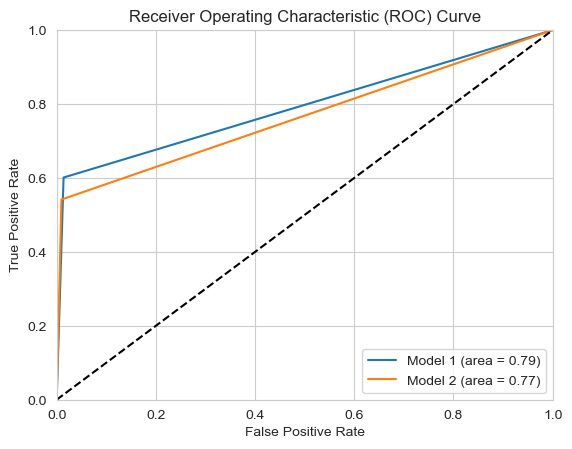

In [20]:
fpr_list = [fpr1, fpr2]
tpr_list = [tpr1, tpr2]
roc_auc_list = [roc_auc1, roc_auc2]
labels = ['Model 1', 'Model 2']

plot_roc_curve(fpr_list, tpr_list, roc_auc_list, labels)

# Model Training: Naive Bayes

In [22]:
# creating the model
naive_bayes = GaussianNB()
# training the model
naive_bayes.fit(X_train,y_train)
# checking the R2 score
print("Training Score:", naive_bayes.score(X_train,y_train))
print("Testing Score:", naive_bayes.score(X_test,y_test))

Training Score: 0.9156626506024096
Testing Score: 0.9029451137884873


In [23]:
# classification report
y_pred = naive_bayes.predict(X_test)
report = metrics.classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95      1350
         1.0       0.50      0.72      0.59       144

    accuracy                           0.90      1494
   macro avg       0.73      0.82      0.77      1494
weighted avg       0.92      0.90      0.91      1494



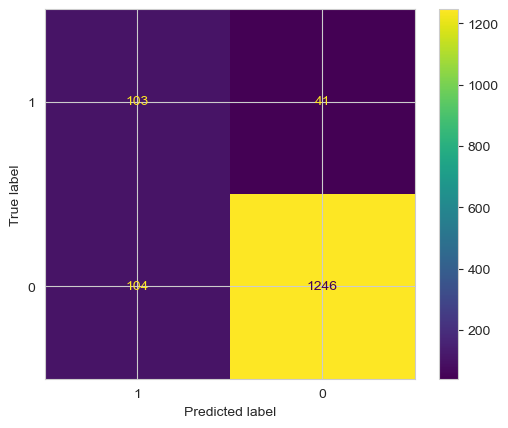

In [27]:
# plotting correlation matrix
plot_confusion_matrix(y_test, y_pred, labels=[1, 0])

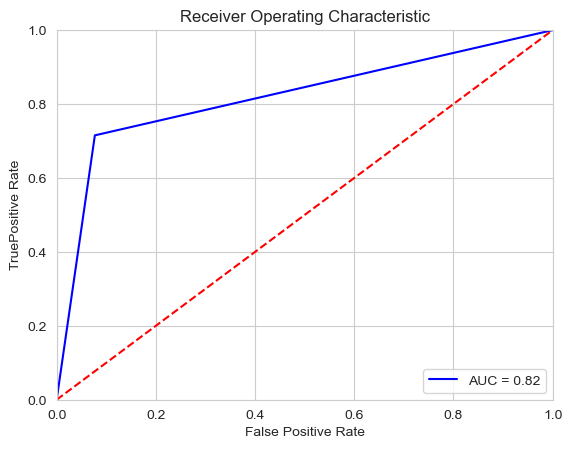

In [24]:
prob = naive_bayes.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test,
                                         y_score=prob,
                                         pos_label=None)

roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TruePositive Rate')
plt.xlabel('False Positive Rate')
plt.show()